In [50]:
from pathlib import Path
import yaml

from matplotlib.colors import LogNorm
import pandas as pd
import seaborn as sns

In [6]:
run_dirs = [p.parent for p in Path('runs').rglob('.hydra')]
len(C), run_dirs[:5]

(180,
 [PosixPath('runs/pku-mmd/all/beta=0.1,latent_dim=32'),
  PosixPath('runs/pku-mmd/all/beta=0.01,latent_dim=16'),
  PosixPath('runs/pku-mmd/all/beta=0.01,latent_dim=128'),
  PosixPath('runs/pku-mmd/all/beta=0,latent_dim=256'),
  PosixPath('runs/pku-mmd/all/beta=0.1,latent_dim=8')])

In [46]:
def read_run_metrics(run_dir):
    params = run_dir / '.hydra' / 'config.yaml'
    with open(params, 'r') as params_file:
        params = yaml.safe_load(params_file)

    log_dir = run_dir / 'lightning_logs' / 'version_0'

    test_metrics = log_dir / 'test_metrics.csv'
    test_metrics = pd.read_csv(test_metrics, index_col=0).squeeze('columns').to_dict()

    checkpoint_dir = log_dir / 'checkpoints' 
    best_checkpoint = next(iter(checkpoint_dir.glob('epoch*.ckpt')))
    best_epoch = int(best_checkpoint.stem.split('-')[0].split('=')[1])

    valid_log = log_dir / 'valid_log.csv'
    valid_log = pd.read_csv(valid_log)

    best_val_epoch = valid_log['val/elbo'].idxmin()
    if best_val_epoch != best_epoch:
        print(f'WARN on {run_dir}: {best_val_epoch=} != {best_epoch=}')

    valid_metrics = valid_log.loc[best_epoch].to_dict()

    return {
        'dataset': run_dir.parts[1],
        'split': run_dir.parts[2],
        'beta': params['beta'],
        'latent_dim': params['latent_dim'],
        'best_epoch': best_epoch,
        **valid_metrics,
        **test_metrics,
    }


In [47]:
metrics = map(read_run_metrics, run_dirs)
metrics = pd.DataFrame(metrics)

WARN on runs/pku-mmd/all/beta=0.1,latent_dim=8: best_val_epoch=61 != best_epoch=58
WARN on runs/pku-mmd/all/beta=10,latent_dim=256: best_val_epoch=501 != best_epoch=49


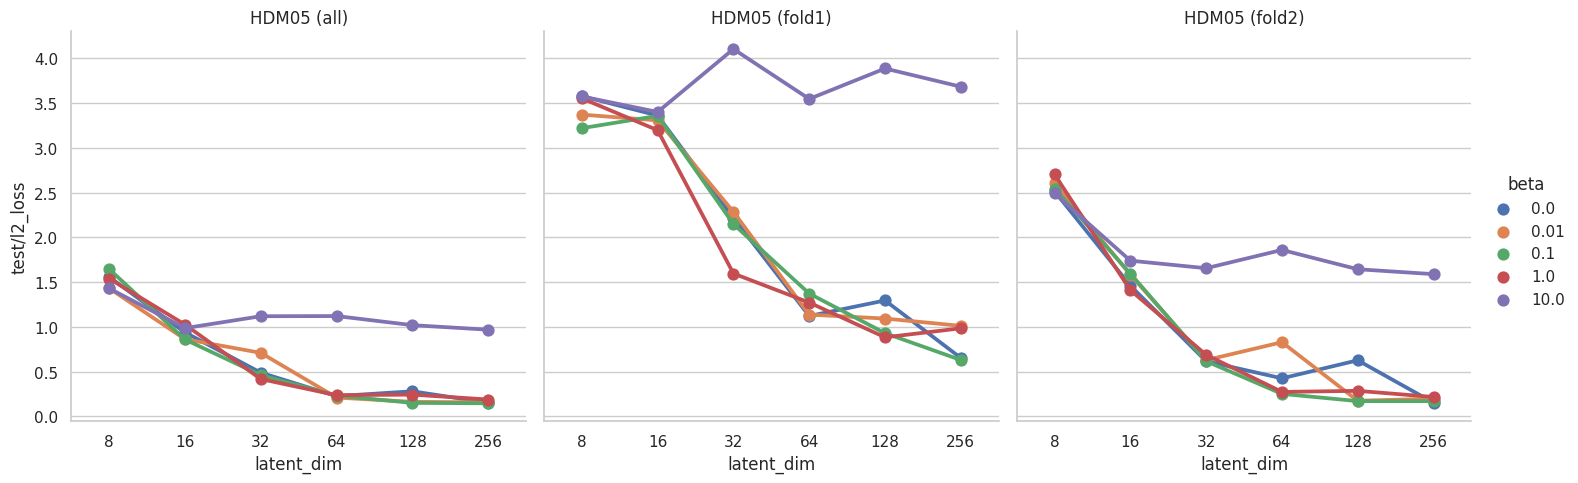

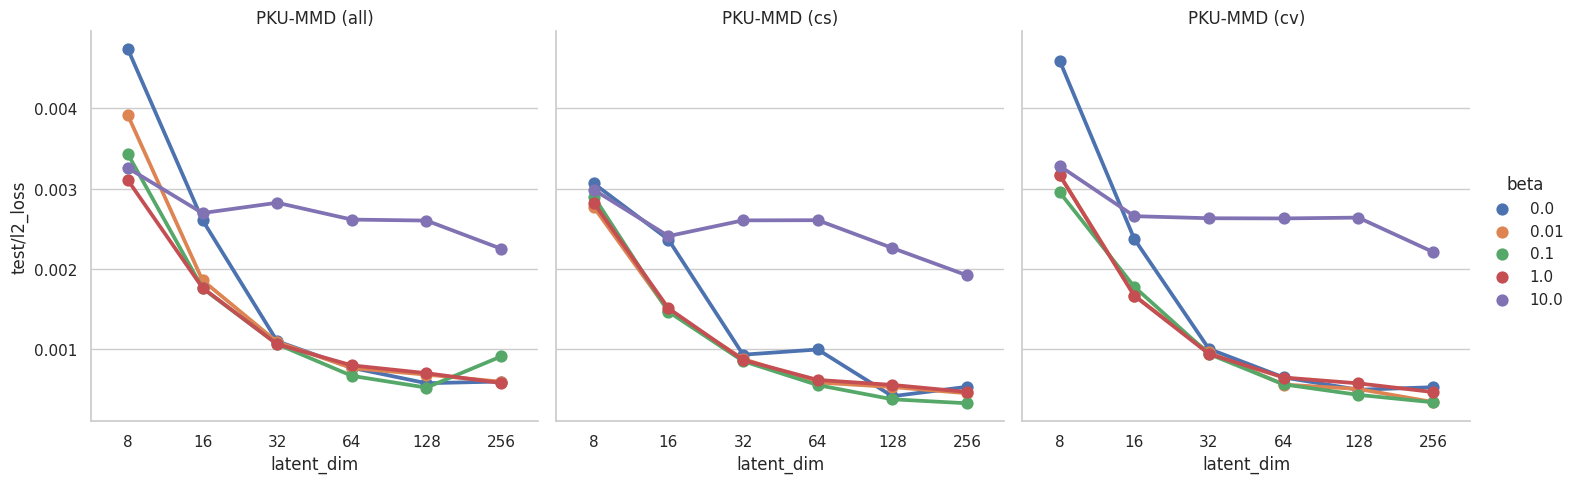

In [77]:
sns.set_theme(style='whitegrid')
for dataset, plot_data in metrics.groupby('dataset'):
    g = sns.catplot(data=plot_data, kind='point', markers='o',
                     col='split', x='latent_dim', y='test/l2_loss',
                     hue='beta', hue_norm=LogNorm())
    g.set_titles(dataset.upper() + ' ({col_name})')